In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

data_path = '/Users/ayemyatwinshwe/repos/data/trading_data/'

In [3]:
df_tokens = pd.read_parquet(data_path + 'earning_call_tokens')
df_tokens.head()

,tokens
0,"[operator, good, day, ladies, gentlemen, welco..."
1,"[operator, good, day, ladies, gentlemen, welco..."
2,"[operator, good, afternoon, welcome, agilent, ..."
3,"[operator, good, afternoon, welcome, agilent, ..."
4,"[operator, good, afternoon, welcome, agilent, ..."


In [4]:
data_tokens = df_tokens['tokens'].to_list()
del df_tokens

In [5]:
%%time
# bigrams and trigrams
bigrams_phrases = Phrases(data_tokens, 
                          min_count= 25, 
                          threshold = 1)
            
trigrams_phrases = Phrases(bigrams_phrases[data_tokens], 
                           min_count= 25, 
                           threshold = 1)

bigram = Phraser(bigrams_phrases)
trigram = Phraser(trigrams_phrases)

data_bigrams = [bigram[doc] for doc in data_tokens]
data_trigrams = [trigram[bigram[doc]] for doc in data_bigrams]

CPU times: user 8min 42s, sys: 13 s, total: 8min 55s
Wall time: 8min 58s


In [6]:
del bigrams_phrases, trigrams_phrases, bigram, trigram, data_bigrams

%%time
model = Word2Vec(sentences=data_trigrams, 
                 sg=1,
                 hs=0,
                 vector_size=300, 
                 window=5, 
                 min_count=50,
                 negative=15,
                 workers=4,
                 alpha=0.05,
                 min_alpha=0.0001)

model.save("word2vec.model")

In [ ]:
model = Word2Vec.load("word2vec.model")
word_vectors = model.wv
word_vectors.save("vectors.kv")
del model
del word_vectors

In [7]:
wv = KeyedVectors.load('vectors.kv')

In [8]:
%%time
word_vecs = []

for i in np.arange(len(data_trigrams)):
    vecs = []
    for x in data_trigrams[i]:
        try:
            vecs.append(wv[x])
        except KeyError:
            pass
    word_vecs.append(vecs)

CPU times: user 1min 8s, sys: 5.43 s, total: 1min 13s
Wall time: 1min 15s


In [9]:
df_word_vecs = pd.DataFrame()
df_word_vecs['vectors'] = word_vecs
df_word_vecs

,vectors
0,"[[1.0666107, -0.28468454, -0.08754885, -0.4464..."
1,"[[1.0666107, -0.28468454, -0.08754885, -0.4464..."
2,"[[0.6297637, -0.32820508, 0.02398203, -0.13134..."
3,"[[0.6297637, -0.32820508, 0.02398203, -0.13134..."
4,"[[0.6297637, -0.32820508, 0.02398203, -0.13134..."
...,...
26232,"[[0.6297637, -0.32820508, 0.02398203, -0.13134..."
26233,"[[0.7034699, -0.28815025, -0.30461752, 0.17155..."
26234,"[[0.7034699, -0.28815025, -0.30461752, 0.17155..."
26235,"[[0.6297637, -0.32820508, 0.02398203, -0.13134..."


In [10]:
df_earnings = pd.read_parquet(data_path + 'earning_calls_1')
df_earnings['returns'] = (df_earnings['next_adjClose'] / df_earnings['prev_adjClose']) -1
df_earnings.head()

,quarter,year,date,content,prev_day,next_7day,prev_adjClose,next_adjClose,returns
symbol,,,,,,,,,
A,1,2019,2019-03-04,"Operator: Good day, ladies and gentlemen, and ...",2019-02-20,2019-03-04,77.049599,78.589417,0.019985
A,2,2019,2019-05-24,"Operator: Good day, ladies and gentlemen. And ...",2019-05-14,2019-05-24,74.701042,67.182785,-0.100645
A,3,2019,2019-08-26,"Operator: Good afternoon, and welcome to the A...",2019-08-14,2019-08-26,64.602371,68.591385,0.061747
A,4,2019,2019-12-05,"Operator: Good afternoon, and welcome to the A...",2019-11-25,2019-12-05,79.221558,80.475121,0.015824
A,1,2020,2020-02-28,Operator: Good afternoon and welcome to the Ag...,2020-02-18,2020-02-28,83.869682,76.233475,-0.091048


In [58]:
df_returns = df_earnings[['quarter', 'returns']]
df_returns.reset_index(drop=True, inplace=True)
df_returns.head()

,quarter,returns
0,1,0.019985
1,2,-0.100645
2,3,0.061747
3,4,0.015824
4,1,-0.091048


In [59]:
del df_earnings

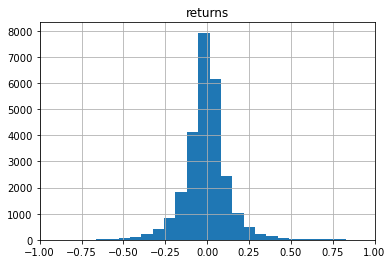

In [11]:
fig, ax = plt.subplots()
df_earnings['returns'].hist(bins=200)
ax.set_title('returns')
ax.set_xlim(-1, 1);

In [63]:
df_word_vecs[['quarter', 'returns']] = df_returns[['quarter', 'returns']]
df_word_vecs.head()

,vectors,quarter,returns
0,"[[1.0666107, -0.28468454, -0.08754885, -0.4464...",1,0.019985
1,"[[1.0666107, -0.28468454, -0.08754885, -0.4464...",2,-0.100645
2,"[[0.6297637, -0.32820508, 0.02398203, -0.13134...",3,0.061747
3,"[[0.6297637, -0.32820508, 0.02398203, -0.13134...",4,0.015824
4,"[[0.6297637, -0.32820508, 0.02398203, -0.13134...",1,-0.091048
